Author: **Daksh Patel**



**Note**
```
As I have used progress bar library, tqdm, it may interefer with the automated test
 scripts to check the outputs. So I would request you to go through the notebook.
```



### if you have `tqdm` installed (colab has tqdm preinstalled but required upgrade), please run:
###  `!pip install --upgrade tqdm`
### Or for fresh installation, please run:
###  `!pip install tqdm`

In [0]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
from random import randint
import copy

## Q1. A)
The generateDataset generates the dataset as per the requirement of Q1. A) - option 3 and plots the dataset after generating it.

In [0]:
def getRandomClass(start=0,end=2, exclude=2):
    randInt = randint(start,end)
    return getRandomClass(start, end, exclude) if randInt == exclude else randInt 

In [0]:
def addNoise(dataset, noise=0.05, numClasses=2):
	if numClasses == 1:
		return dataset
	N = dataset.shape[0]
	np.random.shuffle(dataset)
	for i in range(int(N * noise)):
		dataset[i, -1] = getRandomClass(0, end=numClasses - 1, exclude=dataset[i, -1])
	return dataset


In [0]:
def generateDataset(numExamples, distributionShape, numClasses=2, numOutputs=1, noise=0.05):
	N = int(numExamples / numClasses)
	dataset = None
	plt.figure(figsize=(8, 8))
	plots = []
	diff = numExamples - (N * numClasses)
	if distributionShape == 'g':
		for i in range(numClasses):
			if i == 0:
				x1 = np.random.normal(loc=-2 + (i * 4), scale=1, size=N + diff)
				x2 = np.random.normal(loc=-2 + (i * 4), scale=1, size=N + diff)
				cls = np.ones((N + diff, 1)) * i
				cluster = np.column_stack((x1, x2, cls))
			else:
				x1 = np.random.normal(loc=-2 + (i * 4), scale=1, size=N)
				x2 = np.random.normal(loc=-2 + (i * 4), scale=1, size=N)
				cls = np.ones((N, 1)) * i
				cluster = np.column_stack((x1, x2, cls))
			if i == 0:
				dataset = cluster
			else:
				dataset = np.append(dataset, cluster, axis=0)

	elif distributionShape == 'c':
		num_samples = N
		for i in range(numClasses):
			if i == 0:
				theta = np.linspace(0, 2 * np.pi, N + diff)
				ns = np.random.normal(loc=0, scale=1 / 2, size=(N + diff, 2))
				x_a = np.column_stack((1 * np.cos(theta), 1 * np.sin(theta))) + ns
				cls = np.zeros((N + diff, 1))
				x_a = np.column_stack((x_a, cls))
			else:
				radius = 5 * i
				theta = np.linspace(0, 2 * np.pi, N)
				ns = np.random.uniform(low=-(1), high=(1), size=(N, 2))
				x1 = radius * np.cos(theta)
				x2 = radius * np.sin(theta)
				x_a = np.column_stack((x1, x2)) + ns
				cls = np.ones((N, 1)) * i
				x_a = np.column_stack((x_a, cls))
			if i == 0:
				dataset = x_a
			else:
				dataset = np.append(dataset, x_a, axis=0)
	else:
		pass
	np.random.shuffle(dataset)
	dataset = np.around(addNoise(dataset, noise=noise, numClasses=numClasses), decimals=2)
	plt.scatter(dataset[:, 0], dataset[:, 1], c=dataset[:, 2])
	return dataset


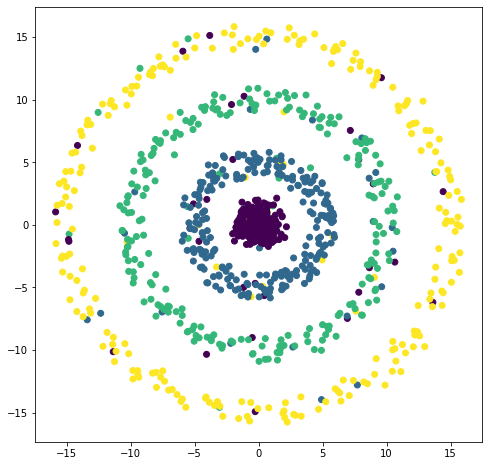

In [6]:
temp = generateDataset(1000, 'c', 4, 4, 0.1)
del temp

## The splitOutputColumn() function is used to split the output columns into `n` columns where `n` is the number of output columns. This is used when output column are greater than 1

In [0]:
def splitOutputColumn(dataset, numClasses):
	if numClasses >= 2:
		labels = dataset[:, -1]
		labels_unique = np.unique(labels)
		i = 0
		for label in labels_unique:
			col = (labels == label).astype('int')
			if i == 0:
				multiOutputDataset = col
			else:
				multiOutputDataset = np.column_stack((multiOutputDataset, col))
			i += 1
		return multiOutputDataset


## The mergeOutputColumn() function is used to merge the the output columns back in 1 columns in order to calculate the score of the model.

In [0]:
def mergeOutputColumn(dataset, numClasses):
	if numClasses >= 2:
		merge = np.argmax(dataset, axis=0)
		return merge

In [0]:
def sigmoid(z):
	sig = 1 / (1 + np.exp(-z))
	return sig


def sigmoid_backward(dPrev, y):
	return dPrev * y * (1 - y)


In [0]:
def softmax(z):
    exp_max = np.exp(z - np.max(z, axis=0, keepdims=True))
    y = exp_max/np.sum(exp_max, axis=0, keepdims=True)
    return y

def softmax_backward(y,t):
    return y-t

In [0]:
def relu(z):
    return np.maximum(0,z)

def relu_backward(dPrev, z):
    return dPrev*((z>0)+0)

In [0]:
def score(predicted_labels, actual_labels):
    x=np.bincount(np.equal(actual_labels.ravel(),predicted_labels.ravel()).astype(int))
    tp=x[1]
    fp=x[0]
    score=tp/(tp+fp)
    return round(score*100,2)

In [0]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon, )
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

## Q1. c) train() function training on sigmoid, relu and linear activation functions.

In [0]:
def train(X, numInput, numHiddenUnits, numOutput, activationType, numIter):
	y = X[:, numInput:]
	X = X[:, :numInput]
	if numOutput > 1:
		y = splitOutputColumn(y, numClasses=numOutput)
	t = y.T
	X = X.T

	W1 = np.random.random((numHiddenUnits, numInput))
	W2 = np.random.random((numOutput, numHiddenUnits))
	lr = 0.0001
	b1 = 1
	b2 = 1
	if activationType == 'sigmoid':
		for i in tqdm(range(numIter), ):
			# ----- Forward Pass -----
			z1 = np.dot(W1, X) + b1
			h1 = sigmoid(z1)
			if numOutput == 1:
				z2 = np.dot(W2, h1) + b2
				y = sigmoid(z2)
			else:
				z2 = np.dot(W2, h1) + b2
				exp_max = np.exp(z2 - np.max(z2, axis=0, keepdims=True))
				y = exp_max / np.sum(exp_max, axis=0, keepdims=True)
			# ----- Backward Pass -----
			if numOutput == 1:
				dy = y - t
				dz2 = sigmoid_backward(dy, y)
			else:
				dz2 = y - t
			dw2 = np.dot(dz2, h1.T)
			db2 = np.sum(dz2, axis=1, keepdims=True)

			dh1 = np.dot(W2.T, dz2)
			dz1 = sigmoid_backward(dh1, h1)
			dw1 = np.dot(dz1, X.T)
			db1 = np.sum(dz1, axis=1, keepdims=True)

			W1 -= lr * dw1
			W2 -= lr * dw2
			b1 -= lr * db1
			b2 -= lr * db2

	elif activationType == 'relu':
		losses = []
		for i in tqdm(range(numIter)):
			z1 = np.dot(W1, X) + b1
			h1 = np.maximum(0, z1)
			if numOutput == 1:
				z2 = np.dot(W2, h1) + b2
				y = 1 / (1 + np.exp(-(z2)))
			else:
				z2 = np.dot(W2, h1) + b2
				exp_max = np.exp(z2 - np.max(z2, axis=0, keepdims=True))
				y = exp_max / np.sum(exp_max, axis=0, keepdims=True)
			if numOutput == 1:
				dy = y - t
				dz2 = dy * y * (1 - y)
			else:
				dz2 = y - t
			dw2 = np.dot(dz2, h1.T)
			db2 = np.sum(dz2, axis=1, keepdims=True)
			dh1 = np.dot(W2.T, dz2)
			dz1 = dh1 * ((z1 > 0) + 0)
			dw1 = np.dot(dz1, X.T)
			db1 = np.sum(dz1, axis=1, keepdims=True)
			W1 -= lr * dw1
			W2 -= lr * dw2
			b1 -= lr * db1
			b2 -= lr * db2
	elif activationType == 'linear':
		m = 0.03
		c = 0.05
		W1 = np.random.random((numHiddenUnits, numInput)) * 0.01
		W2 = np.random.random((numOutput, numHiddenUnits)) * 0.01
		lr = 0.0001
		b1 = 0.01
		b2 = 0.01
		for i in tqdm(range(numIter)):
			# ----- Forward Pass -----
			z1 = np.dot(W1, X) + b1
			h1 = (m * z1) + c
			if numOutput == 1:
				z2 = np.dot(W2, h1) + b2
				y = 1 / (1 + np.exp(-(z2)))
			else:
				z2 = np.dot(W2, h1) + b2
				exp_max = np.exp(z2 - np.max(z2, axis=0, keepdims=True))
				y = exp_max / np.sum(exp_max, axis=0, keepdims=True)
			# ----- Backward Pass -----
			if numOutput == 1:
				dy = y - t
				dz2 = dy * y * (1 - y)
			else:
				dz2 = y - t
			dw2 = np.dot(dz2, h1.T)
			db2 = np.sum(dz2, axis=1, keepdims=True)
			dh1 = np.dot(W2.T, dz2)
			dz1 = dh1 * m
			dw1 = np.dot(dz1, X.T)
			db1 = np.sum(dz1, axis=1, keepdims=True)
			W1 -= lr * dw1
			W2 -= lr * dw2
			b1 -= lr * db1
			b2 -= lr * db2

	return W1, W2, b1, b2  # , losses

In [0]:
def predict(x, W1, W2,b1,b2,activationType='sigmoid', numOutput=1, verbosity=False):
    x=x.T
    if activationType=='sigmoid':
        z1=np.dot(W1,x)+b1
        h1=sigmoid(z1)
        if numOutput==1:
            z2=np.dot(W2,h1)+b2
            y=sigmoid(z2)
        else:
            z2=np.dot(W2,h1)+b2
            exp_max = np.exp(z2 - np.max(z2, axis=0, keepdims=True))
            y = exp_max/np.sum(exp_max, axis=0, keepdims=True)
            y=mergeOutputColumn(np.around(y),numOutput)
        
        return np.around(y)
    elif activationType=='relu':
        z1=np.dot(W1,x)+b1
        h1=np.maximum(0,z1)
        if numOutput==1:
            z2=np.dot(W2,h1)+b2
            y=1/(1+np.exp(-(z2)))
        else:
            z2=np.dot(W2,h1)+b2
            exp_max = np.exp(z2 - np.max(z2, axis=0, keepdims=True))
            y = exp_max/np.sum(exp_max, axis=0, keepdims=True)
            y=mergeOutputColumn(np.around(y),numOutput)
        return np.around(y)
    elif activationType=='linear':
        m=0.03
        c=0.05
        z1=np.dot(W1,x)+b1
        h1=(m*z1)+c
        if numOutput==1:
            z2=np.dot(W2,h1)+b2
            y=1/(1+np.exp(-(z2)))
        else:
            z2=np.dot(W2,h1)+b2
            exp_max = np.exp(z2 - np.max(z2, axis=0, keepdims=True))
            y = exp_max/np.sum(exp_max, axis=0, keepdims=True)
            y=mergeOutputColumn(np.around(y),numOutput)
        return np.around(y)

In [0]:
def score(predicted_labels, actual_labels):
        x=np.bincount(np.equal(actual_labels.ravel(),predicted_labels.ravel()).astype(int))
        tp=x[1]
        fp=x[0]
        score=tp/(tp+fp)
        return round(score*100,2)

## plot_contour() is used to plot the decision boundary for the given configuration of the model.

In [0]:
def plot_contour(X, W1, W2, b1, b2 ,act, numOutput=1):
    plt.figure(figsize=(8, 8))
    cmap=plt.cm.cividis
    X,y=X[:,0:2],X[:,2:]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    x1=np.around(np.arange(x_min,x_max,h),2)
    x2=np.around(np.arange(y_min,y_max,h),2)
    xx,yy=np.meshgrid(x1,x2)
    Z=np.around(predict(np.c_[xx.ravel(),yy.ravel()], W1, W2, b1, b2, act, numOutput=numOutput))
    Z=Z.reshape(xx.shape)
    plt.contourf(x1,x2,Z)
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), cmap=plt.cm.Spectral)
    plt.show()


Dataset Type: g
Activation Type: sigmoid
Hidden Units: 2



Score: 100.0


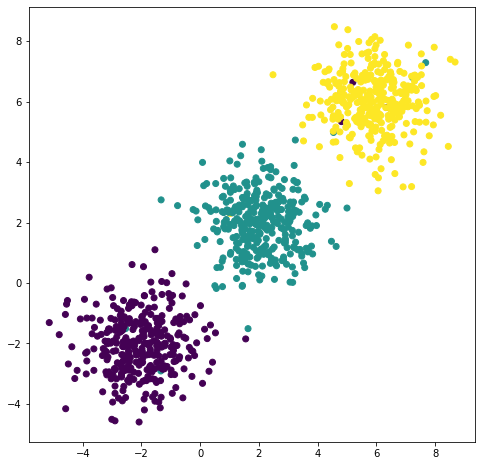

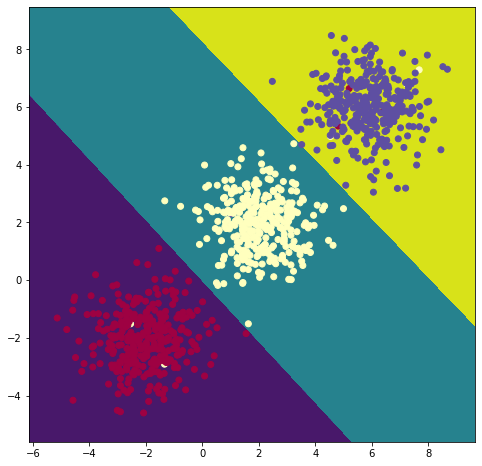

Hidden Units: 3



Score: 100.0


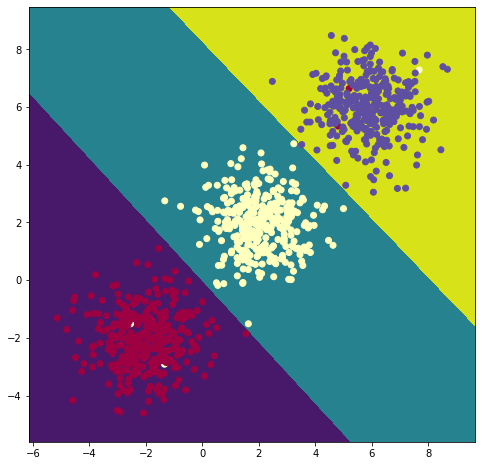

Hidden Units: 4



Score: 100.0


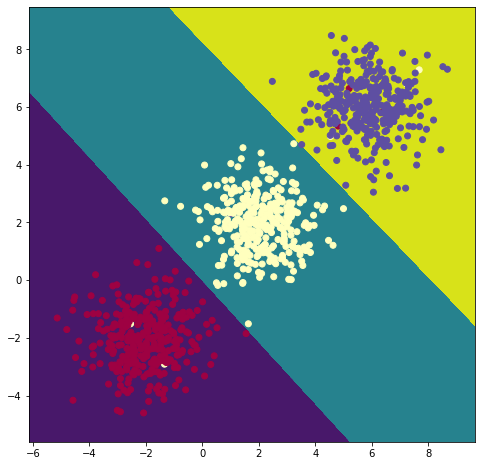

Hidden Units: 5



Score: 100.0


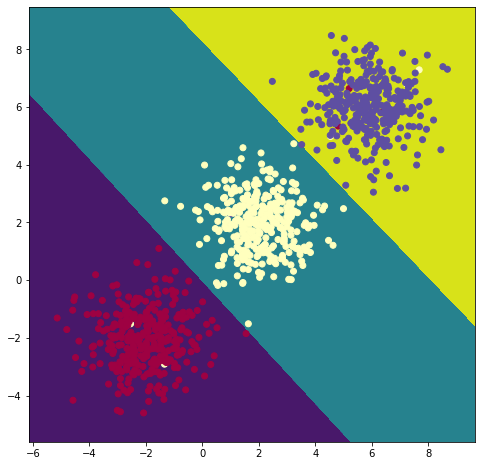

Hidden Units: 6



Score: 99.5


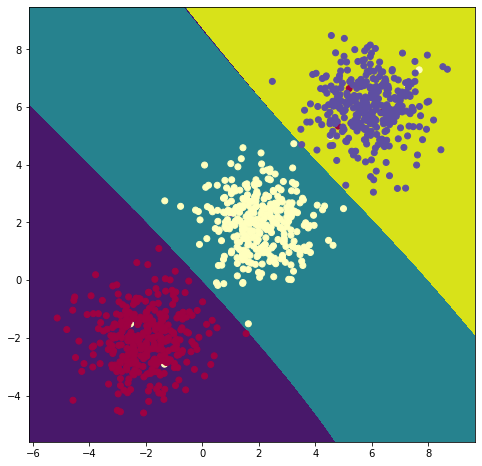

Activation Type: relu
Hidden Units: 2



Score: 99.5


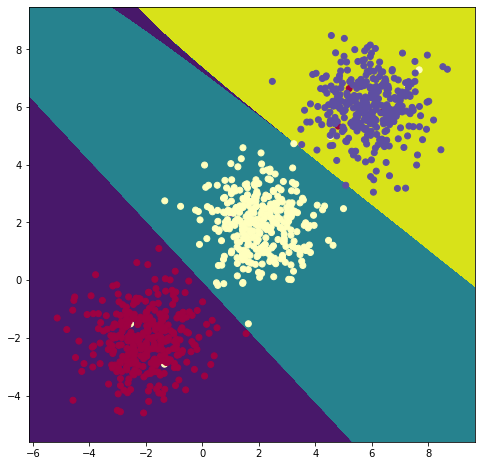

Hidden Units: 3



Score: 99.5


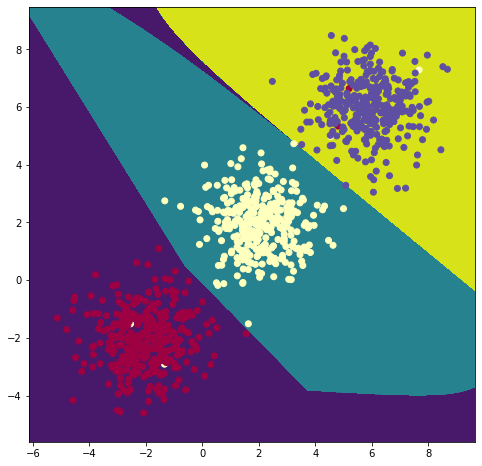

Hidden Units: 4



Score: 100.0


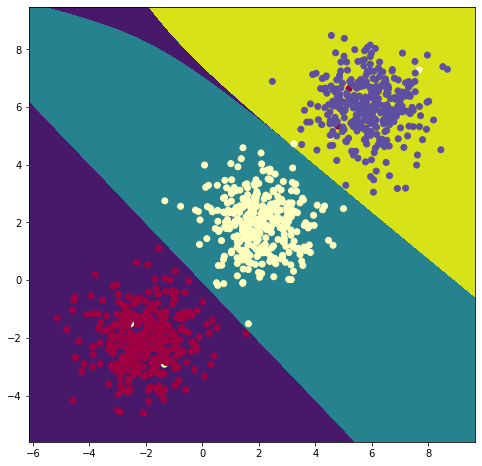

Hidden Units: 5


KeyboardInterrupt: ignored

In [23]:
datasetTypes=['g', 'c']
hiddenunits=[2,3,4,5,6]
actfuncs=['sigmoid', 'relu', 'linear']
for typ in datasetTypes:
    print("Dataset Type: {}".format(typ))
    numOps=3
    numClasses=3
    dataset_1_c=generateDataset(1000, typ, numClasses=numClasses, numOutputs=numOps, noise=0.01)
    x_train=dataset_1_c[:800]
    x_test=dataset_1_c[800:, :2]
    y_test=dataset_1_c[800:, 2:]
    for act in actfuncs:
        print("Activation Type: {}".format(act))
        for hiddenunit in hiddenunits:
            print("Hidden Units: {}".format(hiddenunit))
            W1, W2, b1, b2=train(X=x_train, numInput=2, numHiddenUnits=hiddenunit, numOutput=numOps, numIter=60000, activationType=act)
            preds=predict(x_test, W1, W2, b1, b2, activationType=act, numOutput=numOps)
            accuracy=score(preds, y_test)
            print('Score: {}'.format(accuracy))
            plot_contour(dataset_1_c, W1, W2, b1, b2, act, numOutput=numOps)


## Amongst all the activation functions used in the previous cell, sigmoid creates the smoothest decision boundaries for both the datasets.

## Q1. D), E), F), G), H)
All the requirements in the above mentioned questions are fulfilled in the below cell using the previously defined functions.

In [0]:
class Model:
    def __init__(self, numInputs=2, numOutputs=1, layerSize=2, numHiddenLayers=2, activationType='R'):
    # numInputs: number of inputs to the net
    # numOutputs: number of output units in the output
    # layerSize: the number of units in each hidden layer
    # activationType: either ’L’ (linear), ’S’ (sigmoid), ’R’(reLU)
    # This is the activation type of all hidden layers.
        # The output is a softmax layer if numOutputs is greater than 1, 
        # and a sigmoid otherwise.
        self.numInputs = numInputs
        self.numOutputs = numOutputs
        self.layerSize = layerSize
        self.numHiddenLayers = numHiddenLayers
        self.activationType = activationType
        self.trainLoss=[]
        self.testLoss=[]
    
    def setWeights(self, parameters):
        self.parameters=parameters
    
    def initWeights(self, mu=0, sigma=0.01):
        self.parameters={}

        for i in range(1,self.numHiddenLayers+2):

            if i==1:
                self.parameters['W{}'.format(i)]=np.random.random((self.layerSize, self.numInputs))
                self.parameters['b{}'.format(i)]=1

            elif i==self.numHiddenLayers+1:
                
                self.parameters['W{}'.format(i)]=np.random.random((self.numOutputs, self.layerSize))
                self.parameters['b{}'.format(i)]=1

            else:

                self.parameters['W{}'.format(i)]=np.random.random((self.layerSize, self.layerSize))
                self.parameters['b{}'.format(i)]=1
        
    def setInputs(self, X_train):

        self.X_train=X_train[:,:2].T
        if self.numOutputs>1:
            self.Y_train=splitOutputColumn(X_train[:,2:], numClasses=self.numOutputs)
            self.t=self.Y_train.T

        else:
            self.t=X_train[:,2:].T
    
    def setTest(self, X_test):
        self.X_test=X_test[:,:2].T

        if self.numOutputs>1:
            self.Y_test=splitOutputColumn(X_test[:,2:], numClasses=self.numOutputs).T

        else:
            self.Y_test=X_test[:,2:].T
    
    def forwardPassSigmoid(self, callFrom='train'):
        if callFrom=='train':

            for layer in range(1,self.numHiddenLayers+2):

                if layer!=self.numHiddenLayers+1:

                    self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)], self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                    self.parameters['h{}'.format(layer)]=sigmoid(self.parameters['z{}'.format(layer)])
                    
                else:
                    
                    if self.numOutputs==1:

                        self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)],self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                        self.parameters['y']=sigmoid(self.parameters['z{}'.format(layer)])
                        
                    else:
                        self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)],self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                        self.parameters['y'] = softmax(self.parameters['z{}'.format(layer)])
        else:
            for layer in range(1,self.numHiddenLayers+2):

                    if layer!=self.numHiddenLayers+1:
                        self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)], self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                        self.testParameters['h{}'.format(layer)]=sigmoid(self.testParameters['z{}'.format(layer)])
                        
                    else:
                        
                        if self.numOutputs==1:
                            self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)],self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                            self.testParameters['y']=sigmoid(self.testParameters['z{}'.format(layer)])
                            
                        else:
                            self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)],self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                            self.testParameters['y'] = softmax(self.testParameters['z{}'.format(layer)])
    
    def backwardPassSigmoid(self):
        for layer in range(self.numHiddenLayers+1,0,-1):

            if layer==self.numHiddenLayers+1:
                
                if self.numOutputs==1:
                    
                    self.parameters['dy']=self.parameters['y']-self.t

                    self.parameters['dz{}'.format(layer)]=sigmoid_backward(self.parameters['dy'],self.parameters['y'])
                    self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                    self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)

                    self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                    self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]
                    
                else:

                    self.parameters['dz{}'.format(layer)]=softmax_backward(self.parameters['y'],self.t)
                    self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                    self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)

                    self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                    self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]

            else:

                self.parameters['dh{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer+1)].T, self.parameters['dz{}'.format(layer+1)])

                self.parameters['dz{}'.format(layer)]=sigmoid_backward(self.parameters['dh{}'.format(layer)], self.parameters['h{}'.format(layer)])
                self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)
                
                self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]
    
    def forwardPassRelu(self, callFrom='train'):
        if callFrom=='train':
            
            for layer in range(1,self.numHiddenLayers+2):
                
                if layer!=self.numHiddenLayers+1:
                    self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)], self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                    self.parameters['h{}'.format(layer)]=np.maximum(0,self.parameters['z{}'.format(layer)])
                    
                else:
                    
                    if self.numOutputs==1:
                        self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)],self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                        self.parameters['y']=sigmoid(self.parameters['z{}'.format(layer)])
                        
                    else:
                        self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)],self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                        exp_max = np.exp(self.parameters['z{}'.format(layer)] - np.max(self.parameters['z{}'.format(layer)], axis=0, keepdims=True))

                        self.parameters['y'] = exp_max/np.sum(exp_max, axis=0, keepdims=True)# softmax(self.parameters['z{}'.format(layer)])

        else:
            for layer in range(1,self.numHiddenLayers+2):

                    if layer!=self.numHiddenLayers+1:
                        self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)], self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                        self.testParameters['h{}'.format(layer)]=relu(self.testParameters['z{}'.format(layer)])
                        
                    else:
                        
                        if self.numOutputs==1:
                            self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)],self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                            self.testParameters['y']=sigmoid(self.testParameters['z{}'.format(layer)])
                            
                        else:
                            self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)],self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                            self.testParameters['y'] = softmax(self.testParameters['z{}'.format(layer)])
    
    def backwardPassRelu(self):
        for layer in range(self.numHiddenLayers+1,0,-1):

            if layer==self.numHiddenLayers+1:
                
                if self.numOutputs==1:
        
                    self.parameters['dy']=self.parameters['y']-self.t
                    self.parameters['dz{}'.format(layer)]=sigmoid_backward(self.parameters['dy'],self.parameters['y'])
        
                    self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                    self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)

                    self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                    self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]
                    
                else:
                    self.parameters['dz{}'.format(layer)]=self.parameters['y']-self.t
                    
                    self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                    self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)
                    
                    self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                    self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]

            else:
                self.parameters['dh{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer+1)].T, self.parameters['dz{}'.format(layer+1)])
                self.parameters['dz{}'.format(layer)]=self.parameters['dh{}'.format(layer)]*((self.parameters['z{}'.format(layer)]>0)+0)#(self.parameters['dh{}'.format(layer)], self.parameters['z{}'.format(layer)])
                
                self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)
                
                self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]
    
    def forwardPassLinear(self, callFrom='train'):
        self.parameters['m']=0.03
        self.parameters['c']=0.05
        if callFrom=='train':    
            for layer in range(1,self.numHiddenLayers+2):
                
                if layer!=self.numHiddenLayers+1:
                    self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)], self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                    self.parameters['h{}'.format(layer)]=self.parameters['m']*self.parameters['z{}'.format(layer)] + self.parameters['c']
                    
                else:
                    if self.numOutputs==1:
                        self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)],self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                        self.parameters['y']=sigmoid(self.parameters['z{}'.format(layer)])
                        
                    else:
                        self.parameters['z{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer)],self.parameters['h{}'.format(layer-1)])+self.parameters['b{}'.format(layer)]
                        exp_max = np.exp(self.parameters['z{}'.format(layer)] - np.max(self.parameters['z{}'.format(layer)], axis=0, keepdims=True))

                        self.parameters['y'] = exp_max/np.sum(exp_max, axis=0, keepdims=True)# softmax(self.parameters['z{}'.format(layer)])

        else:
            for layer in range(1,self.numHiddenLayers+2):

                    if layer!=self.numHiddenLayers+1:
                        self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)], self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                        self.testParameters['h{}'.format(layer)]=self.parameters['m']*self.testParameters['z{}'.format(layer)] + self.parameters['c']
                        
                    else:
                        
                        if self.numOutputs==1:
                            self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)],self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                            self.testParameters['y']=sigmoid(self.testParameters['z{}'.format(layer)])
                            
                        else:
                            self.testParameters['z{}'.format(layer)]=np.dot(self.testParameters['W{}'.format(layer)],self.testParameters['h{}'.format(layer-1)])+self.testParameters['b{}'.format(layer)]
                            self.testParameters['y'] = softmax(self.testParameters['z{}'.format(layer)])

    def backwardPassLinear(self):
        for layer in range(self.numHiddenLayers+1,0,-1):

            if layer==self.numHiddenLayers+1:
                
                if self.numOutputs==1:
        
                    self.parameters['dy']=self.parameters['y']-self.t
                    self.parameters['dz{}'.format(layer)]=sigmoid_backward(self.parameters['dy'],self.parameters['y'])
        
                    self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                    self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)

                    self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                    self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]
                    
                else:
                    self.parameters['dz{}'.format(layer)]=self.parameters['y']-self.t
                    
                    self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                    self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)
                    
                    self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                    self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]

            else:
                self.parameters['dh{}'.format(layer)]=np.dot(self.parameters['W{}'.format(layer+1)].T, self.parameters['dz{}'.format(layer+1)])
                self.parameters['dz{}'.format(layer)]=self.parameters['dh{}'.format(layer)]*self.parameters['m']#(self.parameters['dh{}'.format(layer)], self.parameters['z{}'.format(layer)])
                
                self.parameters['dw{}'.format(layer)]=np.dot(self.parameters['dz{}'.format(layer)],self.parameters['h{}'.format(layer-1)].T)
                self.parameters['db{}'.format(layer)]=np.sum(self.parameters['dz{}'.format(layer)], axis=1, keepdims=True)
                
                self.parameters['W{}'.format(layer)]-=self.lr*self.parameters['dw{}'.format(layer)]
                self.parameters['b{}'.format(layer)]-=self.lr*self.parameters['db{}'.format(layer)]

    def calculateLoss(self, callFrom='train'):
        if callFrom=='train':
            if self.numOutputs==1:
                trainLoss=np.square(self.parameters['y'] - self.t).mean()

            else:
                trainLoss=cross_entropy(self.parameters['y'], self.t)
            return trainLoss
        else:
            if self.numOutputs==1:
                y=self.testParameters['y']
                testLoss=np.square(self.testParameters['y'] - self.Y_test).mean()

            else:
                testLoss=cross_entropy(self.testParameters['y'], self.Y_test)
            return testLoss
    
    def plotDecisionBoundary(self, dataset):
        X=dataset
        X,y=X[:,0:2],X[:,2:]
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        h = 0.01
        x1=np.around(np.arange(x_min,x_max,h),2)
        x2=np.around(np.arange(y_min,y_max,h),2)
        xx,yy=np.meshgrid(x1,x2)
        Z=np.around(self.predict(np.c_[xx.ravel(),yy.ravel()]))
        Z=Z.reshape(xx.shape)
        plt.contourf(x1,x2,Z,cmap=plt.cm.cividis)
        plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), cmap=plt.cm.Spectral)
        plt.show()

    def train(self, numIters=100, lr=0.01, verbose=False):

        self.parameters['h0']=self.X_train
        self.lr=lr

        if self.activationType=='S':
            for i in tqdm(range(numIters)):
            
                self.forwardPassSigmoid(callFrom='train')
                self.backwardPassSigmoid()

                trainLoss=self.calculateLoss()            
                testLoss=self.test()

                if i%10000==0 and verbose:

                    trainStatement="Train Loss @ iteration# {} : {}".format(i, round(trainLoss,4)).ljust(50)
                    testStatement="Test Loss @ iteration# {} : {}".format(i, round(testLoss,4)).ljust(50)
                    print(' {} | {} '.format(trainStatement, testStatement))

                self.trainLoss.append(trainLoss)
                self.testLoss.append(testLoss)

        elif self.activationType=='R':
            for i in tqdm(range(numIters)):
                self.forwardPassRelu(callFrom='train')

                self.backwardPassRelu()

                trainLoss=self.calculateLoss()
                testLoss=self.test()

                if i%10000==0 and verbose:

                    trainStatement="Train Loss @ iteration# {} : {}".format(i, round(trainLoss,4)).ljust(50)
                    testStatement="Test Loss @ iteration# {} : {}".format(i, round(testLoss,4)).ljust(50)
                    print(' {} | {}'.format(trainStatement, testStatement))
                self.trainLoss.append(trainLoss)
                self.testLoss.append(testLoss)
        
        elif self.activationType=='L':
            for i in tqdm(range(numIters)):

                self.forwardPassLinear(callFrom='train')
                self.backwardPassLinear()

                trainLoss=self.calculateLoss()
                testLoss=self.test()

                if i%10000==0 and verbose:

                    trainStatement="Train Loss @ iteration# {} : {}".format(i, round(trainLoss,4)).ljust(50)
                    testStatement="Test Loss @ iteration# {} : {}".format(i, round(testLoss,4)).ljust(50)
                    print(' {} | {}'.format(trainStatement, testStatement))
                self.trainLoss.append(trainLoss)
                self.testLoss.append(testLoss)

        
        return self.trainLoss, self.testLoss

    def test(self):

        self.testParameters=copy.deepcopy(self.parameters)
        self.testParameters['h0']=self.X_test

        if self.activationType=='S':
            self.forwardPassSigmoid(callFrom='test')

        elif self.activationType=='R':
            self.forwardPassRelu(callFrom='test')
        
        elif self.activationType=='L':
            self.forwardPassLinear(callFrom='test')

        
        testLoss=self.calculateLoss(callFrom='test')

        return testLoss

    def predict(self, X1):

        self.testParameters=copy.deepcopy(self.parameters)
        self.testParameters['h0']=X1.T
        if self.activationType=='S':
            self.forwardPassSigmoid(callFrom='test')
        elif self.activationType=='R':
            self.forwardPassRelu(callFrom='test')
        elif self.activationType=='L':
            self.forwardPassLinear(callFrom='test')
        
        if self.numOutputs==1:
            y=self.testParameters['y']
        
        else:
            y=mergeOutputColumn(np.around(self.testParameters['y']),self.numOutputs)
        
        return np.around(y)

In [0]:
def plotLoss(trainLoss, testLoss):
    xTrain=list(range(1,len(trainLoss)+1))
    xTest=list(range(1,len(testLoss)+1))
    plt.plot(xTrain, trainLoss, label='Train Loss')
    plt.plot(xTest, testLoss, label='test Loss')
    plt.legend()
    plt.show()

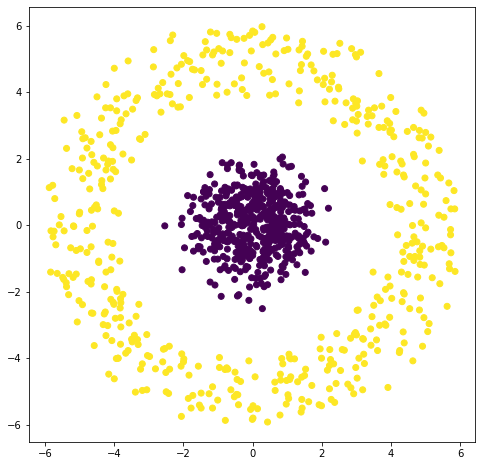

In [45]:
numClasses=2
dataset=generateDataset(numExamples=1000,distributionShape='c',noise=0, numClasses=numClasses)
X_train=dataset[:800]
X_test=dataset[800:]
if numClasses<=2:
    numOps=1
else:
    numOps=numClasses

In [46]:
nLayers=2
net = Model(numInputs=2, numOutputs=numOps, layerSize=4, numHiddenLayers=nLayers, activationType='S')
net.setInputs(X_train)
net.setTest(X_test)
net.initWeights(mu=1, sigma=0.1)
trainLoss, testLoss=net.train(60000, 0.0001)
preds=net.predict(X_test[:,:2])
print("Score: ",score(preds,X_test[:,2:]))


Score:  100.0


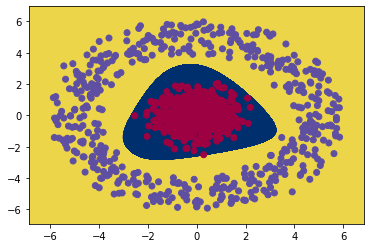

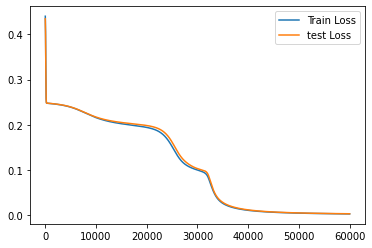

In [47]:
net.plotDecisionBoundary(dataset)
plotLoss(trainLoss, testLoss)


Score: 100.0


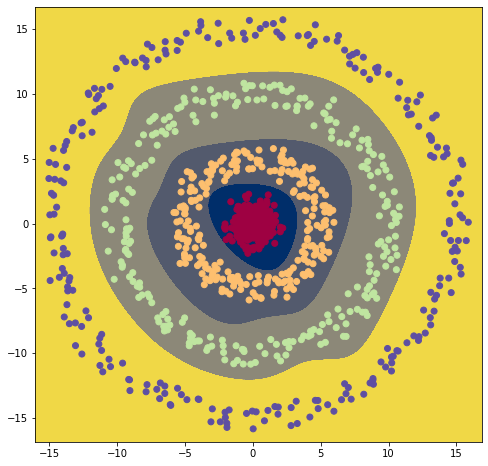

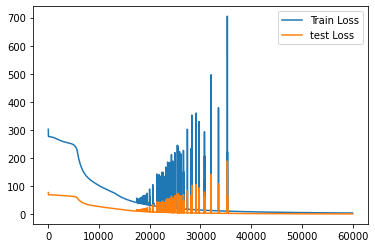

In [44]:
numClasses=4
dataset=generateDataset(numExamples=1000,distributionShape='c',noise=0, numClasses=numClasses)
X_train=dataset[:800]
X_test=dataset[800:]
if numClasses<=2:
    numOps=1
else:
    numOps=numClasses
nLayers=2
net = Model(numInputs=2, numOutputs=numOps, layerSize=4, numHiddenLayers=nLayers, activationType='S')
net.setInputs(X_train)
net.setTest(X_test)
net.initWeights(mu=1, sigma=0.1)
trainLoss, testLoss=net.train(60000, 0.0001)
preds=net.predict(X_test[:,:2])
print("Score:",score(preds,X_test[:,2:]))
net.plotDecisionBoundary(dataset)
plotLoss(trainLoss, testLoss)

## From the above output it is observed that in more than 1 ouput column scenario, the value of loss for both train as well as test fluctuates a lot before reaching the optimum value. 

Layer: 1, Hidden Units: 1



35.0


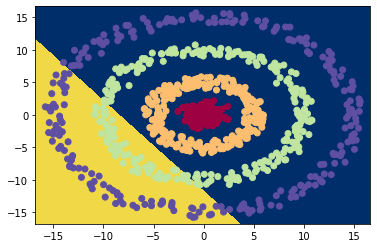

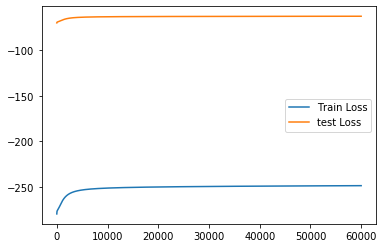

Layer: 1, Hidden Units: 2



41.5


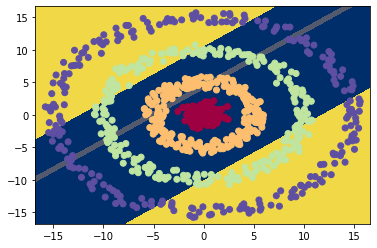

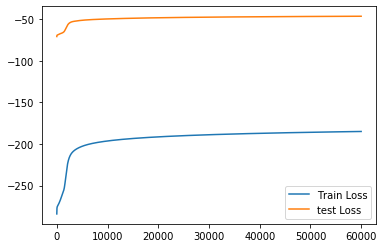

Layer: 1, Hidden Units: 4



99.0


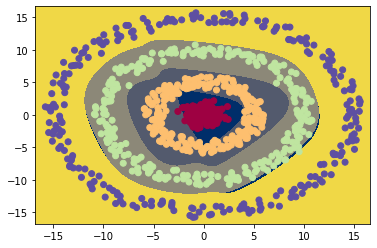

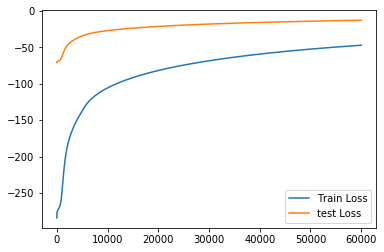

Layer: 1, Hidden Units: 6



98.5


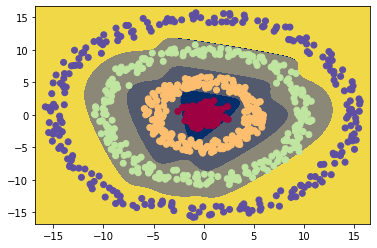

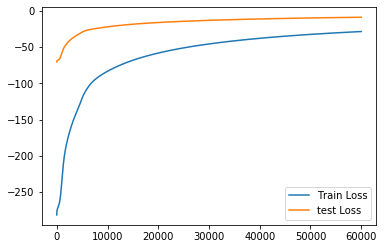

Layer: 1, Hidden Units: 8



99.0


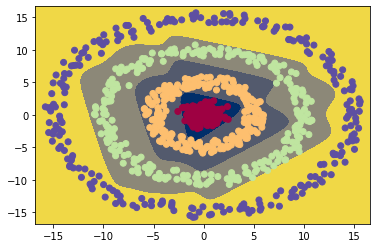

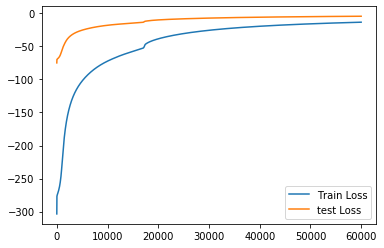

Layer: 1, Hidden Units: 10



98.5


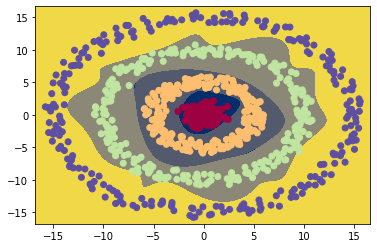

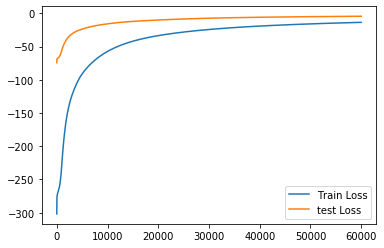

Layer: 1, Hidden Units: 15


KeyboardInterrupt: ignored

In [0]:
for act in ['S', 'R', 'L']:
    for layer in [1,2,4]:
        for hiddenUnits in [1,2,4,6]:
            print('Layer: {}, Hidden Units: {}'.format(layer, hiddenUnits))
            nLayers=layer
            net = Model(numInputs=2, numOutputs=numOps, layerSize=hiddenUnits, numHiddenLayers=nLayers, activationType=act)
            net.setInputs(X_train)
            net.setTest(X_test)
            net.initWeights(mu=1, sigma=0.1)
            trainLoss, testLoss=net.train(60000, 0.0001)
            preds=net.predict(X_test[:,:2])
            print(score(preds,X_test[:,2:]))
            net.plotDecisionBoundary(dataset)
            plotLoss(trainLoss, testLoss)

# References

[Parametric equation of circle](https://www.mathopenref.com/coordparamcircle.html)

[numpy.random.normal](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html)

[numpy.random.randn](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randn.html?highlight=numpy%20random%20randn#numpy.random.randn)

[tqdm library](https://github.com/tqdm/tqdm)

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

